In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
df = pd.read_csv("cars.csv")
print("\nDataset Loaded. Shape:", df.shape)

print('\nInfo:')
print(df.info())


Dataset Loaded. Shape: (65535, 10)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            65535 non-null  object 
 1   model            65535 non-null  object 
 2   price_in_pln     65535 non-null  float64
 3   mileage          65535 non-null  object 
 4   gearbox          65535 non-null  object 
 5   engine_capacity  65535 non-null  object 
 6   fuel_type        65535 non-null  object 
 7   city             65535 non-null  object 
 8   voivodeship      65535 non-null  object 
 9   year             65535 non-null  object 
dtypes: float64(1), object(9)
memory usage: 5.0+ MB
None


In [12]:
# Look for inappropriate values in the dataset
def clean_a_column(df, column_name, should_be_numeric):    
    if should_be_numeric:
        # Keep only rows where the value is numeric
        df = df[pd.to_numeric(df[column_name], errors='coerce').notna()].copy()
        df[column_name] = pd.to_numeric(df[column_name])
        # print(f"After removing non-numeric {column_name} rows. Shape:", df.shape)
    else:
        # Keep only rows where the value is NOT numeric
        df = df[pd.to_numeric(df[column_name], errors='coerce').isna()].copy()
        df[column_name] = df[column_name].astype(str)
        # print(f"After removing numeric {column_name} values. Shape:", df.shape)
    return df

def clean_all_columns(df):
    numeric_columns = ['mileage', 'engine_capacity', 'year', 'price_in_pln']
    categorical_columns = ['brand', 'model', 'gearbox', 'fuel_type', 'city', 'voivodeship']    
    for num_col in numeric_columns:
        print(f"Processing numeric column: {num_col}")
        df = clean_a_column(df, num_col, True)
    for cat_col in categorical_columns:
        print(f"Processing categorical column: {cat_col}")
        df = clean_a_column(df, cat_col, False)
    return df


df = clean_all_columns(df)

# Removing luxury cars -> outliers
df = df[df['price_in_pln'] <= 1500000]
# Removing cars with mileage over 600000 -> outliers
df = df[df['mileage'] <= 600000]
# Removing engine capacity clear data errors over 8000 -> outliers
df = df[df['engine_capacity'] <= 8000]
df = df[df['engine_capacity'] > 0]
# Removing duplicate rows
df.drop_duplicates(inplace=True)

Processing numeric column: mileage
Processing numeric column: engine_capacity
Processing numeric column: year
Processing numeric column: price_in_pln
Processing categorical column: brand
Processing categorical column: model
Processing categorical column: gearbox
Processing categorical column: fuel_type
Processing categorical column: city
Processing categorical column: voivodeship


In [13]:
def process_model_name(model, brand):
    model_parts = model.replace('ë', 'e').replace('+', ' ').split()
    brand_words = []
    if brand == 'land-rover':
        brand_words.extend(['land', 'rover', 'range'])
    elif brand.lower() == 'mercedes-benz':
        brand_words.append(brand.replace('-', ' '))
    else:
        brand_words.extend(brand.split('-'))
    
    model_parts_copy = model_parts.copy()
    for w in model_parts_copy:
        w_for_comparison = w.replace('-', ' ')
        if any(brand_part.lower() == w_for_comparison.lower() for brand_part in brand_words):
            model_parts.remove(w)
    
    if len(model_parts) == 0:
        return "Unknown", ""
    
    # Special handling for Land Rover Range Rover
    if brand == 'land-rover' and 'Range' in model and 'Rover' in model:
        original_parts = model.split()
        range_rover_end = -1
        for i, part in enumerate(original_parts):
            if part.lower() == 'rover' and i > 0 and original_parts[i-1].lower() == 'range':
                range_rover_end = i
                break
        if range_rover_end != -1 and range_rover_end + 1 < len(original_parts):
            next_part = original_parts[range_rover_end + 1]
            # Check if the next part is numeric (contains digits)
            if any(char.isdigit() for char in next_part):
                model_name = ['Range', 'Rover']
            else:
                model_name = [next_part]
        else:
            model_name = ['Range', 'Rover']
    else:
        model_name = [model_parts[0]]
    # Special handling for BMW Series
    if brand.lower() == 'bmw' and model_name[0].lower() == 'seria':
        if len(model_parts) > 1:
            model_name.append(model_parts[1])            
    # Special handling for Mercedes-Benz Classes
    if brand.lower() == 'mercedes-benz' and model_name[0].lower() == 'klasa':
        if len(model_parts) > 1:
            model_name.append(model_parts[1])       

    return ' '.join(model_name), ' '.join([w for w in model_parts if w not in model_name])


df['model_cleaned'] = df['model']
df['configuration'] = df['model']
for brand in df['brand'].unique():
    # print(f"Processing brand: {brand}")
    mask = df['brand'] == brand
    # Remove brand name from model
    processed_models = df.loc[mask, 'model_cleaned'].apply(lambda x: process_model_name(x, brand))
    df.loc[mask, 'model_cleaned'] = [result[0] for result in processed_models]
    df.loc[mask, 'configuration'] = [result[1] for result in processed_models]
    # Remove rows where model_cleaned is 'Unknown'
    df = df[df['model_cleaned'] != 'Unknown']
    # Save if has configuration
    df['optional'] = (df['configuration'] != '').astype(int)


# ---------------------- Ordinal encoding for gearbox ----------------------
gearbox_mapping = {value: i for i, value in enumerate(df['gearbox'].unique())}
# # print("Gearbox mapping:", gearbox_mapping)
df['gearbox'] = df['gearbox'].map(gearbox_mapping)


# ---------------------- Dropping useless features ----------------------
df.drop(['city', 'voivodeship'], axis=1, inplace=True)

In [14]:
# Split df in train, val and test sets
X = df.drop('price_in_pln', axis=1)
y = df['price_in_pln']

temp_df, val_df, y_temp, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
train_df, test_df, y_train, y_test = train_test_split(temp_df, y_temp, test_size=0.1, random_state=42)

print("\nTrain set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)


# One hot encode the 'fuel_type' column
encoder = OneHotEncoder(sparse_output=False, drop='first')
fuel_encoded_train = encoder.fit_transform(train_df[['fuel_type']])
feature_names = encoder.get_feature_names_out(['fuel_type'])
fuel_encoded_val = encoder.transform(val_df[['fuel_type']])
fuel_encoded_test = encoder.transform(test_df[['fuel_type']])
train_encoded = pd.DataFrame(fuel_encoded_train, columns=feature_names, index=train_df.index).astype(int)
val_encoded = pd.DataFrame(fuel_encoded_val, columns=feature_names, index=val_df.index).astype(int)
test_encoded = pd.DataFrame(fuel_encoded_test, columns=feature_names, index=test_df.index).astype(int)

train_df = pd.concat([train_df.drop('fuel_type', axis=1), train_encoded], axis=1)
val_df = pd.concat([val_df.drop('fuel_type', axis=1), val_encoded], axis=1)
test_df = pd.concat([test_df.drop('fuel_type', axis=1), test_encoded], axis=1)



# ---------------------- Target encoding for brand and model ----------------------
# Compute target encoding, on training data, for brand and model
train_data = pd.concat([train_df, y_train], axis=1)
brand_model_means = train_data.groupby(['brand', 'model_cleaned'])['price_in_pln'].mean()
def apply_target_encoding(X_set, target_means, fallback_value):
    return X_set.apply(
        lambda row: target_means.get((row['brand'], row['model_cleaned']), fallback_value), 
        axis=1
    )
fallback = y_train.mean()  # Use training mean as fallback
train_df['brand_model_target'] = apply_target_encoding(train_df, brand_model_means, fallback)
val_df['brand_model_target'] = apply_target_encoding(val_df, brand_model_means, fallback)
test_df['brand_model_target'] = apply_target_encoding(test_df, brand_model_means, fallback)



# ---------------------- Normalize mileage, age and engine capacity ----------------------
# Compute age column
last_year = train_df['year'].max()
train_df['age'] = last_year - train_df['year']
val_df['age'] = last_year - val_df['year']
test_df['age'] = last_year - test_df['year']

# In order to avoid data leakage, we will normalize the data ONLY ACCORDING to values in the train set.
max_age = train_df['age'].max()
min_age = train_df['age'].min()
max_mileage = train_df['mileage'].max()
min_mileage = train_df['mileage'].min()
max_engine_capacity = train_df['engine_capacity'].max()
min_engine_capacity = train_df['engine_capacity'].min()

# Normalize mileage, age and engine capacity using train set min and max
train_df['age_normalized'] = (train_df['age'] - min_age) / (max_age - min_age)
val_df['age_normalized'] = (val_df['age'] - min_age) / (max_age - min_age)
test_df['age_normalized'] = (test_df['age'] - min_age) / (max_age - min_age)

train_df['mileage_normalized'] = np.log1p(train_df['mileage'])
val_df['mileage_normalized'] = np.log1p(val_df['mileage'])
test_df['mileage_normalized'] = np.log1p(test_df['mileage'])

train_df['engine_capacity_normalized'] = (df['engine_capacity'] - min_engine_capacity) / (max_engine_capacity - min_engine_capacity)
val_df['engine_capacity_normalized'] = (val_df['engine_capacity'] - min_engine_capacity) / (max_engine_capacity - min_engine_capacity)
test_df['engine_capacity_normalized'] = (test_df['engine_capacity'] - min_engine_capacity) / (max_engine_capacity - min_engine_capacity)

train_df.drop(['model', 'configuration', 'year', 'age', 'mileage', 'engine_capacity', 'model_cleaned', 'brand'], axis=1, inplace=True)
val_df.drop(['model', 'configuration', 'year', 'age', 'mileage', 'engine_capacity', 'model_cleaned', 'brand'], axis=1, inplace=True)
test_df.drop(['model', 'configuration', 'year', 'age', 'mileage', 'engine_capacity', 'model_cleaned', 'brand'], axis=1, inplace=True)

train_df.to_csv("cars_cleaned.csv", index=False)
train_df.info()


Train set shape: (45261, 10)
Validation set shape: (5588, 10)
Test set shape: (5030, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 45261 entries, 2613 to 55762
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gearbox                     45261 non-null  int64  
 1   optional                    45261 non-null  int64  
 2   fuel_type_Benzyna+CNG       45261 non-null  int64  
 3   fuel_type_Benzyna+LPG       45261 non-null  int64  
 4   fuel_type_Diesel            45261 non-null  int64  
 5   fuel_type_Elektryczny       45261 non-null  int64  
 6   fuel_type_Hybryda           45261 non-null  int64  
 7   brand_model_target          45261 non-null  float64
 8   age_normalized              45261 non-null  float64
 9   mileage_normalized          45261 non-null  float64
 10  engine_capacity_normalized  45261 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 4.1 MB


### Start by dropping both city and voivodeship because:

High cardinality problem - 3047 cities will likely cause overfitting
Logical reasoning - Car value should be intrinsic to the car itself
Cleaner model - Easier to interpret and explain
Real-world applicability - Your model will be more generalizable
Test this hypothesis by comparing model performance with/without these features. If removing them doesn't hurt performance (or even improves it), you've proven your point!

The key car value drivers should be: brand, model, age, mileage, engine capacity, fuel type, and gearbox - all intrinsic to the vehicle itself.


### How to prove whether city or voivodeship adds value:

🔬 Step 1: Train two models
Model A: With all features

Model B: Without city and voivodeship

🔢 Step 2: Compare performance (e.g., using cross-validation)
Evaluate using metrics like:

RMSE (Root Mean Squared Error)

MAE (Mean Absolute Error)

If there's no significant drop in performance, you can safely drop them.

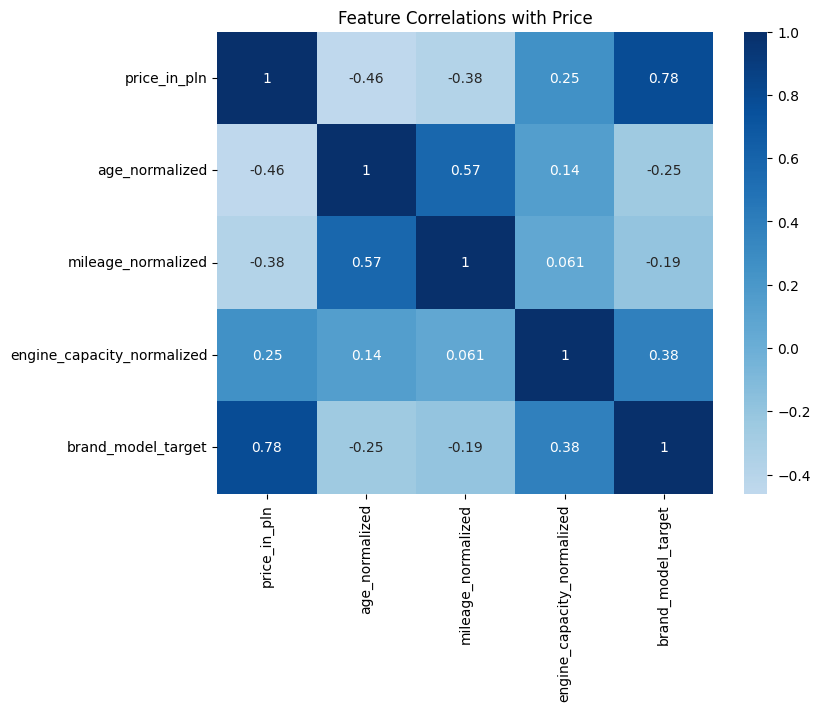

In [15]:
# Calculate correlation matrix
numeric_cols = ['price_in_pln', 'age_normalized', 'mileage_normalized', 'engine_capacity_normalized', 'brand_model_target']
train_data = pd.concat([train_df, y_train], axis=1)
correlation_matrix = train_data[numeric_cols].corr()

# Visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', center=0)
plt.title('Feature Correlations with Price')
plt.show()

We should normalize all your data — training, validation, test — using the same min and max values, but you must compute those values only from the training set. Here's why and how that works:

Why not use test data for normalization?
Using the test data to compute min and max would leak information about the test distribution into your training pipeline — which means your model gets to “see” the test set during training in an indirect way. That leads to overfitting and inflated accuracy on test data, which is misleading.



## It's time to train a model!


In [17]:
# Random seed
random_state = 42

# Dictionary of models with parameters
models = {
    'DecisionTree': {
        'name': 'Decision Tree',
        'estimator': DecisionTreeRegressor(random_state=random_state),
        'param': [{'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10]}]
    },
    'RandomForest': {
        'name': 'Random Forest',
        'estimator': RandomForestRegressor(random_state=random_state),
        'param': {
            'n_estimators': [50, 100, 110, 120, 130, 150],
            'max_depth': [5, 8, 10, 13, 15, 20],
        }
    },
    'GradientBoosting': {
        'name': 'Gradient Boosting',
        'estimator': GradientBoostingRegressor(random_state=random_state),
        'param': {
            'n_estimators': [250, 270, 300, 320, 330, 350],
            'learning_rate': [0.15, 0.17, 0.19, 0.2, 0.21, 0.23],
            'max_depth': [2, 3, 4, 5]
        }
    }, 
    'XGBoost': {
    'name': 'XGBoost Regressor',
    'estimator': XGBRegressor(objective='reg:squarederror', random_state=random_state),
    'param': {
        'n_estimators': [100, 150, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }
}
}

result = []

for key, model_info in models.items():
    print(f"\nTraining model: {model_info['name']}")
    
    estimator = model_info['estimator']
    param_grid = model_info['param']
    
    if param_grid: 
        grid = GridSearchCV(estimator, param_grid, cv=3, scoring='r2', n_jobs=-1)
        grid.fit(train_df, y_train)
        best_model = grid.best_estimator_
        print(f"Best parameters: {grid.best_params_}")
    
    else:
        best_model = estimator.fit(train_df, y_train)

    # Save the model performance
    # dump(best_model, f"model_weights/{key}_model.joblib")
    
    y_pred = best_model.predict(test_df)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    result.append({
        'model': model_info['name'],
        'mae': mae,
        'mse': mse,
        'r2': r2
    })

# Show results
results_df = pd.DataFrame(result)
results_df = results_df.sort_values(by='r2', ascending=False)
print("\nModel Performance Summary:")
print(results_df)


Training model: Decision Tree
Best parameters: {'max_depth': 10, 'min_samples_split': 10}

Training model: Random Forest
Best parameters: {'max_depth': 10, 'n_estimators': 150}

Training model: Gradient Boosting
Best parameters: {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 330}

Training model: XGBoost Regressor
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}

Model Performance Summary:
               model           mae           mse        r2
1      Random Forest  19949.688872  1.757441e+09  0.857696
2  Gradient Boosting  20532.237226  1.777616e+09  0.856062
0      Decision Tree  20604.033257  1.926096e+09  0.844039
3  XGBoost Regressor  21011.580547  2.111180e+09  0.829052


In [ ]:
model_lgbm = LGBMRegressor()
param={
    'num_leaves':[32,64],
    'min_data_in_leaf':[1,5,10],
    'colsample_bytree':[0.8,1],
    'n_estimators':[50, 100]
}
GS_LGB = GridSearchCV(model_lgbm, param, cv=10)
GS_LGB.fit(train_df, y_train)
lgb_pred = GS_LGB.predict(test_df)
print("\t\tError Table")
print('LGB Mean Absolute Error: ', mean_absolute_error(lgb_pred, y_test))
print("LGB R Squared Error :", r2_score(y_test, lgb_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 32189, number of used features: 11
[LightGBM] [Info] Start training from score 81882.431700
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_i

## Results
So, the prediction isn't very good. I see 2 main reasons.

1. Lack of features
There are a lot of important features, that are not mentioned in the dataset. The presence of cracks or dents, the general condition of the car interior, the previous number of owners, how long the ad has been on the site, as well as the color of the car. Defects should obviously reduce the cost. Also, a car of a non-standard color may have a lower cost than the classic ones. It can be seen from the diagram that the number of machines for which the algorithm made a big mistake is much larger, as well as the average error is also larger. This means that he often overstates the price than understates. This may indicate just that there are cars with an undervalued value in the sample for one reason or another.

2. Human factor
Due to the fact that the price is set by a person, he may intentionally overstate it or, conversely, underestimate it out of ignorance. Of course, this should not create such a big problem, but it also contributes to the blurring of prices.

Also, as you can see, with a linear decrease in dimension (PCA), 2 groups were formed within which the data can be conditionally represented as linear. At first I thought that this was due to an underestimation of the price due to external defects, but in this case there should also be a group with inflated prices, and there is no such group. I'm not sure what this means and whether I'm interpreting it correctly. I will be glad to comment

## Reflection
The overall prediction power is not good enough. I believe there are several ways to further improve it:

More Comprehensive Data Cleaning and Feature Engineering: I noticed that many rows have the same mileage (km), engine capacity (cm3), and even the year but are sold at different prices. I'm not sure if these are input errors or not. Considering this during data cleaning could help in building a better model. Additionally, it would be beneficial to take the brand and model into consideration when building the model. The brand awareness and popularity of a model can significantly influence the price. However, one of the challenges is that the input formats for different brands and models are quite different. This is one reason why I only chose BMW to build the prediction model.

Hyperparameter Tuning: By utilizing the Optuna module, we can tune the hyperparameters of the XGBoost and LGB models to achieve better results.

More Data: I believe the dataset is insufficient to build a reliable model for predicting used car prices. There are several reasons for this. Firstly, the total volume of data is not large enough; we require more training data. Secondly, the information in the dataset may overlook some important factors, such as the color, type, whether it is new/second/third hand, and so on. Moreover, macroeconomic indicators might also influence the demand and price of used cars.

Overall, there are numerous ways to train a better model, and I thoroughly enjoyed working on this project. If you have any suggestions or comments, please let me know. Thank you! Don't forget to UPVOTE!